In [1]:
 from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install tensorflow tensorflow-datasets librosa soundfile


In [4]:
# @title
# 최초 1회만 실행 압축 해제

import zipfile
import os

# 압축 파일 경로와 추출 경로 설정
data_dir = '/content/drive/My Drive/Yepi/Data'
ravdess_zip_path = f'{data_dir}/RAVDESS.zip'
tess_zip_path = f'{data_dir}/TESS.zip'
savee_zip_path = f'{data_dir}/SAVEE.zip'

# 압축 해제 디렉토리 설정
ravdess_dir = f'{data_dir}/RAVDESS'
tess_dir = f'{data_dir}/TESS'
savee_dir = f'{data_dir}/SAVEE'

if not os.path.exists(tess_dir):
    with zipfile.ZipFile(tess_zip_path, 'r') as zip_ref:
        zip_ref.extractall(tess_dir)
    print("TESS 데이터셋 압축 해제 완료")

if not os.path.exists(savee_dir):
    with zipfile.ZipFile(savee_zip_path, 'r') as zip_ref:
        zip_ref.extractall(savee_dir)
    print("SAVEE 데이터셋 압축 해제 완료")

if not os.path.exists(ravdess_dir):
    with zipfile.ZipFile(ravdess_zip_path, 'r') as zip_ref:
        zip_ref.extractall(ravdess_dir)
    print("RAVDESS 데이터셋 압축 해제 완료")

RAVDESS 데이터셋 압축 해제 완료


In [6]:
# 파일 로드 및 경로 설정
import glob
import os

# 데이터셋 루트 디렉토리 설정
ravdess_dir = '/content/drive/My Drive/Yepi/Data/RAVDESS'
tess_dir = '/content/drive/My Drive/Yepi/Data/TESS'
savee_dir = '/content/drive/My Drive/Yepi/Data/SAVEE'

# 각 데이터셋의 파일 로드
ravdess_files = glob.glob(f"{ravdess_dir}/Actor_*/**/*.wav", recursive=True)
tess_files = glob.glob(f"{tess_dir}/**/*.wav", recursive=True)
savee_files = glob.glob(f"{savee_dir}/**/*.wav", recursive=True)

# 각 리스트의 파일 개수 확인
print(f"RAVDESS 파일 개수: {len(ravdess_files)}")
print(f"TESS 파일 개수: {len(tess_files)}")
print(f"SAVEE 파일 개수: {len(savee_files)}")

# 파일들을 하나의 리스트로 합치기
filenames = ravdess_files + tess_files + savee_files

# 총 파일 개수 확인
if len(filenames) == 0:
    print("파일이 로드되지 않았습니다. 경로를 확인하세요.")
else:
    print(f"발견된 파일 개수: {len(filenames)}")

    # 데이터셋별 비율 확인
print(f"RAVDESS 비율: {len(ravdess_files) / len(filenames) * 100:.2f}%")
print(f"TESS 비율: {len(tess_files) / len(filenames) * 100:.2f}%")
print(f"SAVEE 비율: {len(savee_files) / len(filenames) * 100:.2f}%")


RAVDESS 파일 개수: 1440
TESS 파일 개수: 5600
SAVEE 파일 개수: 960
발견된 파일 개수: 8000
RAVDESS 비율: 18.00%
TESS 비율: 70.00%
SAVEE 비율: 12.00%


    Audio-only files of all actors (01-24) are available as two separate zip files (~200 MB each):

    Speech file (Audio_Speech_Actors_01-24.zip, 215 MB) contains 1440 files: 60 trials per actor x 24 actors = 1440.
    Song file (Audio_Song_Actors_01-24.zip, 198 MB) contains 1012 files: 44 trials per actor x 23 actors = 1012.
    
    
    Each of the RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

    Filename identifiers
        Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
        Vocal channel (01 = speech, 02 = song).
        Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
        Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
        Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
        Repetition (01 = 1st repetition, 02 = 2nd repetition).
        Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

    Filename example: 02-01-06-01-02-01-12.mp4
        Video-only (02)
        Speech (01)
        Fearful (06)
        Normal intensity (01)
        Statement "dogs" (02)
        1st Repetition (01)
        12th Actor (12)
        Female, as the actor ID number is even.

In [8]:
from collections import Counter
# 감정 맵핑
ravdess_emotions_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}


# 라벨링 함수 정의
def get_emotion_label_ravdess(filename):
    """RAVDESS 데이터셋에서 감정 라벨 추출"""
    try:
        emotion_code = filename.split('-')[2]
        return ravdess_emotions_map.get(emotion_code, "unknown")
    except IndexError:
        print(f"RAVDESS 파일 형식 오류: {filename}")
        return "unknown"

# TESS 데이터셋 라벨링 수정
def get_emotion_label_tess(filename):
    """TESS 데이터셋에서 감정 라벨 추출"""
    if 'ps' in filename.lower():  # 파일명에 'ps' 포함 여부 확인 (대소문자 무시)
        return 'happy'
    emotion = filename.split('_')[-1].replace('.wav', '').lower()
    if emotion == 'fear':  # 'fear'를 'fearful'로 통합
        return 'fearful'
    return emotion


# SAVEE 데이터셋 라벨링
def get_emotion_label_savee(file):
    savee_map = {
        'a': 'angry', 'd': 'disgust', 'f': 'fearful',
        'h': 'happy', 'n': 'neutral', 'sa': 'sad', 'su': 'surprised'
    }

    # 파일명에서 감정 코드를 추출
    base_name = os.path.basename(file).lower()
    emotion_code = base_name[:2]  # 첫 두 글자를 기본으로 추출
    if emotion_code not in savee_map:  # 두 글자가 감정 코드에 없으면 한 글자만 추출
        emotion_code = base_name[0]

    # 감정 매핑
    return savee_map.get(emotion_code, "unknown")


In [9]:
# Lets visualise how a single sound File looks like and its features
fid = filenames[200]
print(fid)

/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_04/03-01-04-01-01-01-04.wav


In [10]:
# 라벨링 수행
labeled_data = []
failed_files = []  # 실패한 파일 저장

# RAVDESS 라벨링
for file in ravdess_files:
    label = get_emotion_label_ravdess(file)
    if label != "unknown":
        labeled_data.append((file, label))
    else:
        failed_files.append(file)

# TESS 라벨링
for file in tess_files:
    label = get_emotion_label_tess(file)  # 'fear'가 'fearful'로 통합됨
    if label != "unknown":
        labeled_data.append((file, label))
    else:
        failed_files.append(file)

# SAVEE 라벨링
for file in savee_files:
    label = get_emotion_label_savee(file)
    if label != "unknown":
        labeled_data.append((file, label))
    else:
        failed_files.append(file)

# 통합 라벨별 파일 개수 출력
from collections import Counter
label_counts = Counter([label for _, label in labeled_data])
print("\n라벨별 파일 개수:")
for label, count in label_counts.items():
    print(f"{label}: {count} files")


# 데이터셋별 라벨링 실패율 계산
total_files = len(ravdess_files) + len(tess_files) + len(savee_files)
failed_count = len(failed_files)

print(f"\n전체 파일 수: {total_files}")
print(f"라벨링 성공 파일 수: {len(labeled_data)}")
print(f"라벨링 실패 파일 수: {failed_count}")
print(f"라벨링 실패율: {failed_count / total_files * 100:.2f}%")

# 실패한 파일 목록 출력
if failed_count > 0:
    print("\n라벨링 실패 파일 목록:")
    for failed_file in failed_files:
        print(failed_file)
else:
    print("\n모든 파일이 라벨링에 성공했습니다!")


라벨별 파일 개수:
neutral: 1136 files
calm: 192 files
happy: 1912 files
sad: 1112 files
angry: 1112 files
fearful: 1112 files
disgust: 1112 files
surprised: 312 files

전체 파일 수: 8000
라벨링 성공 파일 수: 8000
라벨링 실패 파일 수: 0
라벨링 실패율: 0.00%

모든 파일이 라벨링에 성공했습니다!


In [11]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.7 MB/s eta 0:00:00


In [12]:
!pip install librosa

In [13]:
import os
import glob
import librosa
import soundfile as sf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [14]:
import soundfile as sf # Make sure the soundfile module is imported as sf

sf = sf.SoundFile(fid) # Use sf to call SoundFile from the soundfile module
data = sf.read(dtype="float32")
sample_rate = sf.samplerate

In [15]:
print(f"First 5 filenames: {filenames[:5]}")

First 5 filenames: ['/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav']


In [16]:
sf

SoundFile('/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_04/03-01-04-01-01-01-04.wav', mode='r', samplerate=48000, channels=1, format='WAV', subtype='PCM_16', endian='FILE')

In [17]:
data[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [18]:
duration = data.shape[0]/sample_rate
duration

3.370041666666667

In [19]:
sample_rate

48000

In [20]:
import IPython.display as ipd
ipd.Audio(fid)

### EXPLORATION

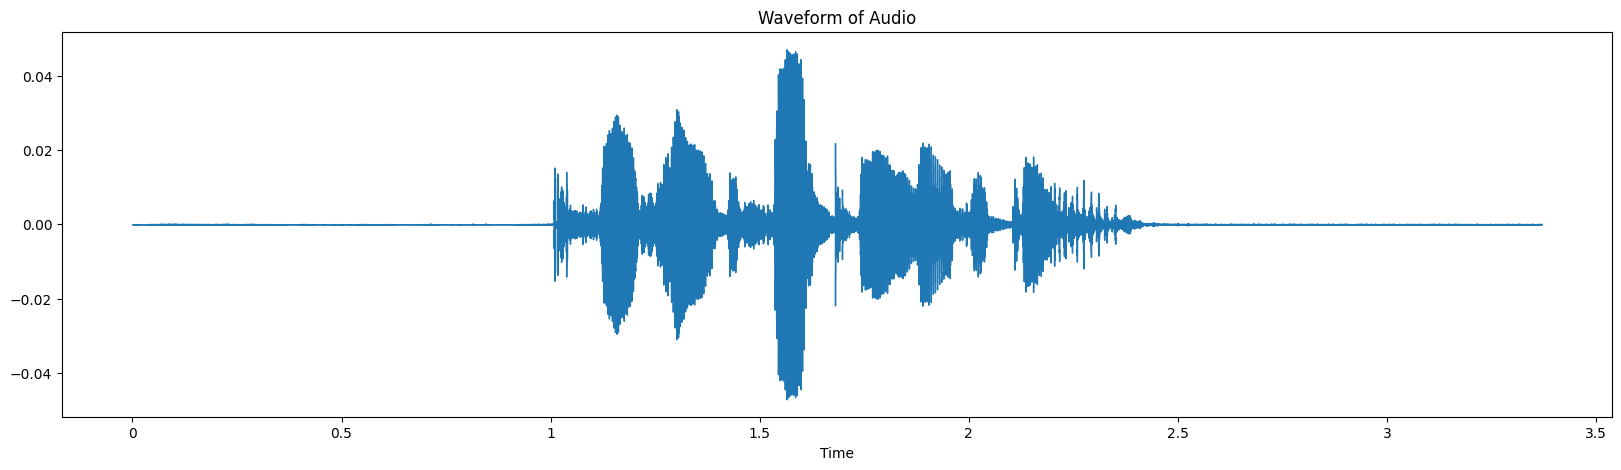

In [21]:
import matplotlib.pyplot as plt

# Plot the waveform using waveshow
plt.figure(figsize=(20, 5))
librosa.display.waveshow(data, sr=sample_rate)
plt.title('Waveform of Audio')
plt.show()

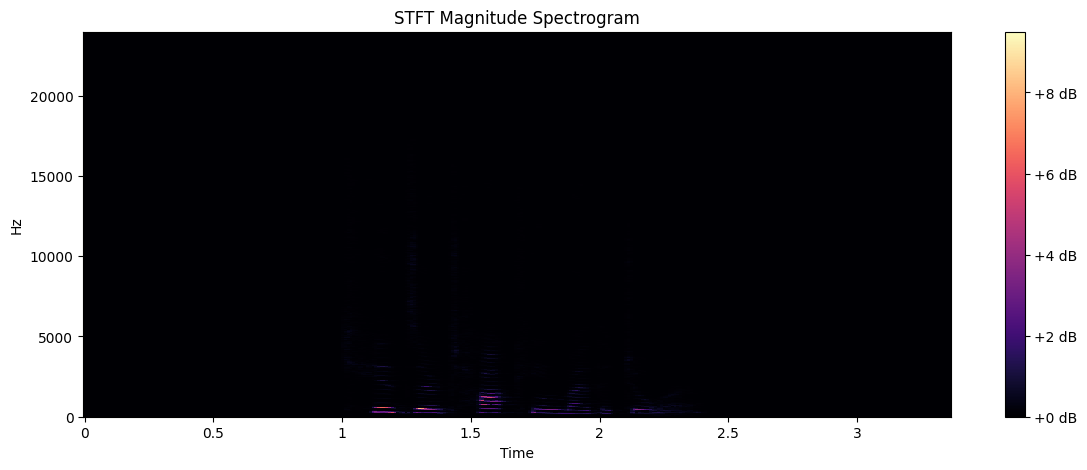

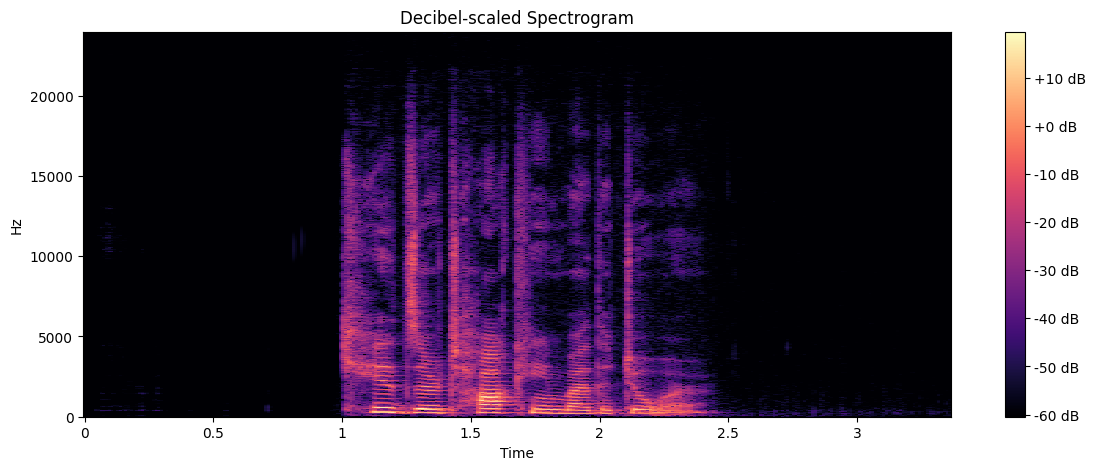

In [22]:
# Computing the Short-Time Fourier Transform (STFT)
x_stft = librosa.stft(data)

# Converting the amplitude to decibels (log scale)
x_db = librosa.amplitude_to_db(abs(x_stft))

# Plotting the raw STFT spectrogram (not usually done this way, for comparison)
plt.figure(figsize=(14, 5))
librosa.display.specshow(abs(x_stft), sr=sample_rate, x_axis='time', y_axis='hz')
plt.title('STFT Magnitude Spectrogram')
plt.colorbar(format="%+2.0f dB")
plt.show()

# Plotting the decibel-scaled spectrogram (this is the more common visualization)
plt.figure(figsize=(14, 5))
librosa.display.specshow(x_db, sr=sample_rate, x_axis='time', y_axis='hz')
plt.title('Decibel-scaled Spectrogram')
plt.colorbar(format="%+2.0f dB")
plt.show()


Shape of Mel Spectrogram: (128, 316)


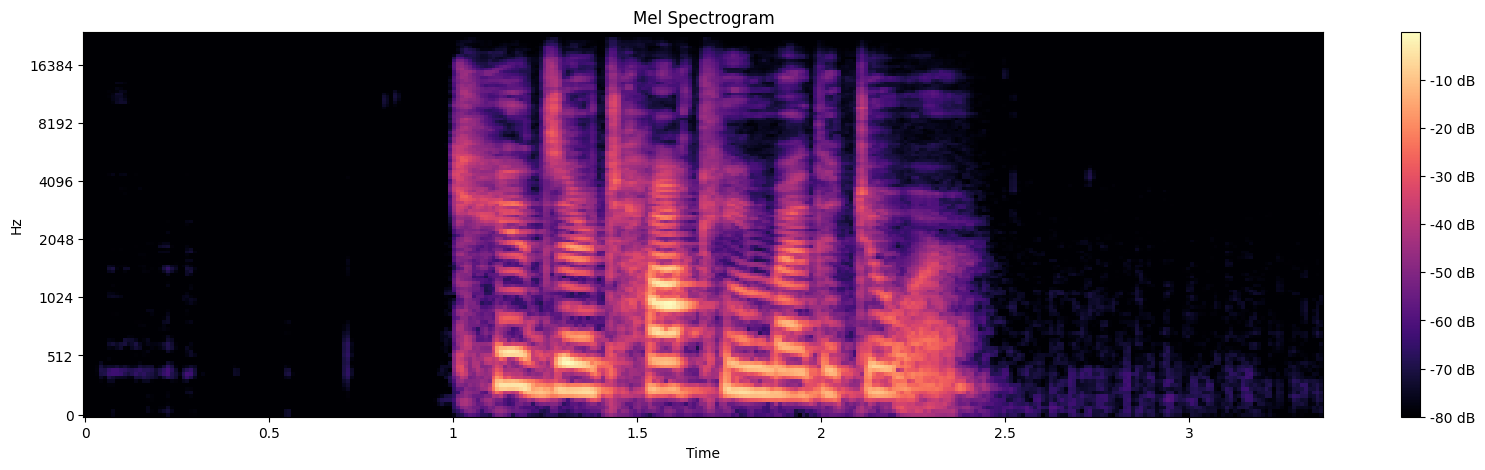

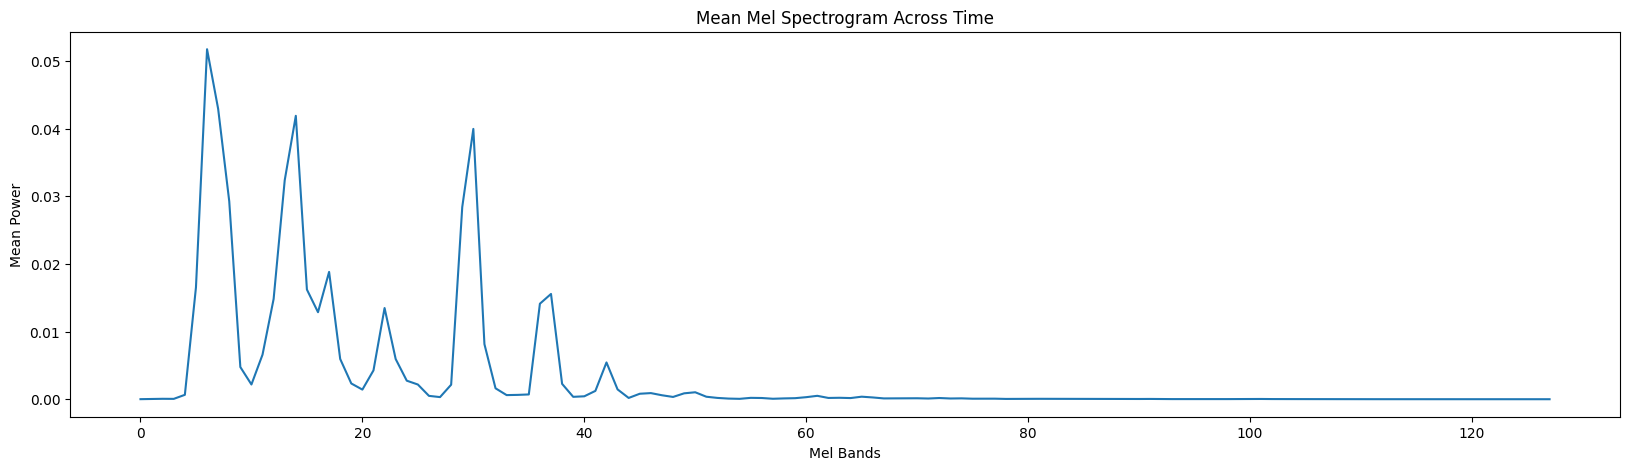

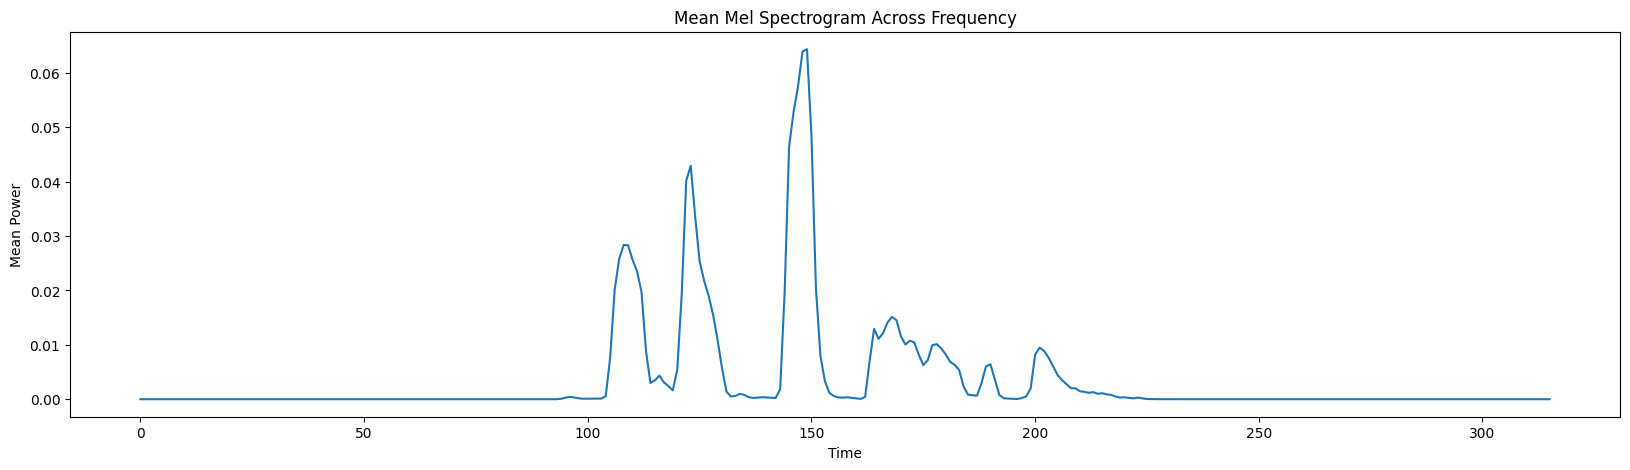

In [23]:
# Computing a Mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=data, sr=sample_rate)
print('Shape of Mel Spectrogram:', mel_spec.shape)

plt.figure(figsize=(20, 5))
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                         sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

# Ploting the mean of the Mel spectrogram across time (mean per frequency band)
plt.figure(figsize=(20, 5))
plt.plot(np.mean(mel_spec, axis=1))
plt.title('Mean Mel Spectrogram Across Time')
plt.xlabel('Mel Bands')
plt.ylabel('Mean Power')
plt.show()

# Ploting the mean of the Mel spectrogram across frequency (mean per time frame)
plt.figure(figsize=(20, 5))
plt.plot(np.mean(mel_spec, axis=0))
plt.title('Mean Mel Spectrogram Across Frequency')
plt.xlabel('Time')
plt.ylabel('Mean Power')
plt.show()


In [24]:
print(f"First 5 filenames: {filenames[:5]}")


First 5 filenames: ['/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav']


Shape of MFCCs: (13, 316)


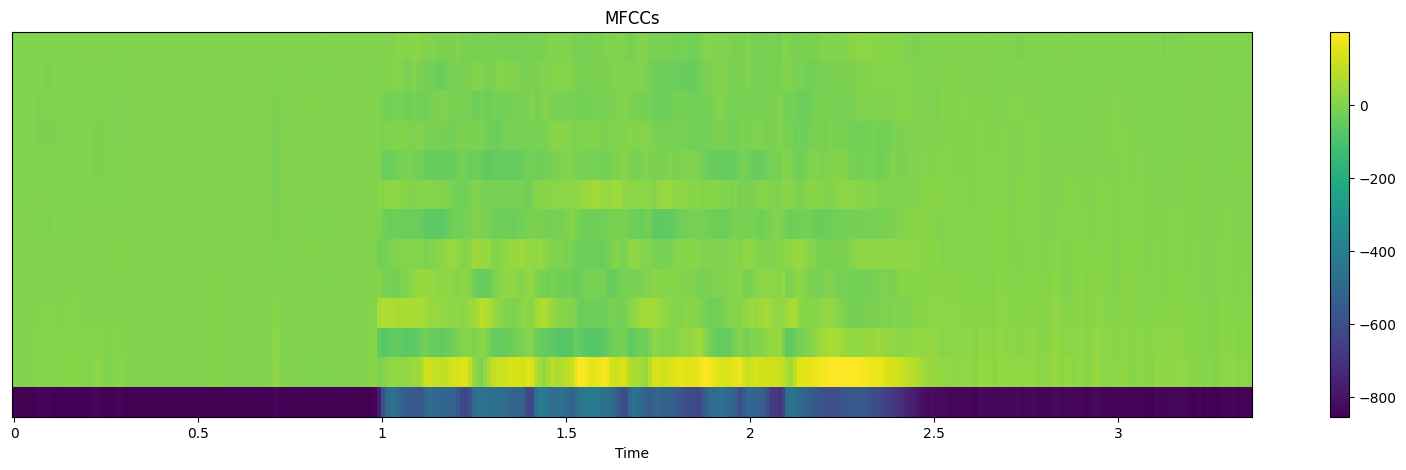

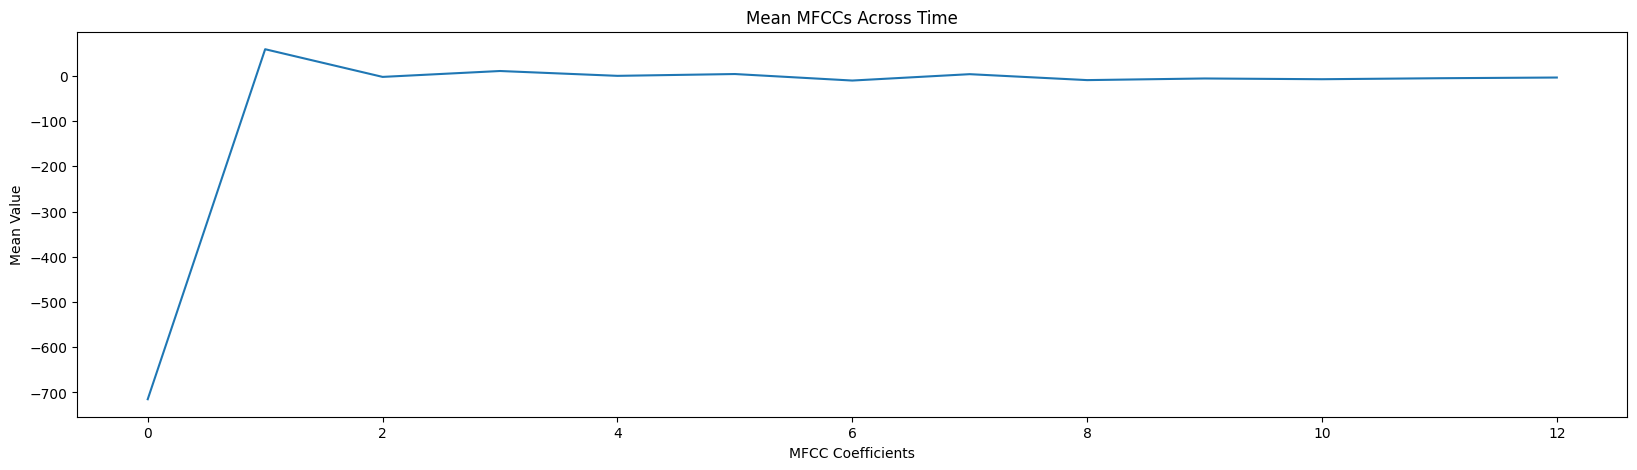

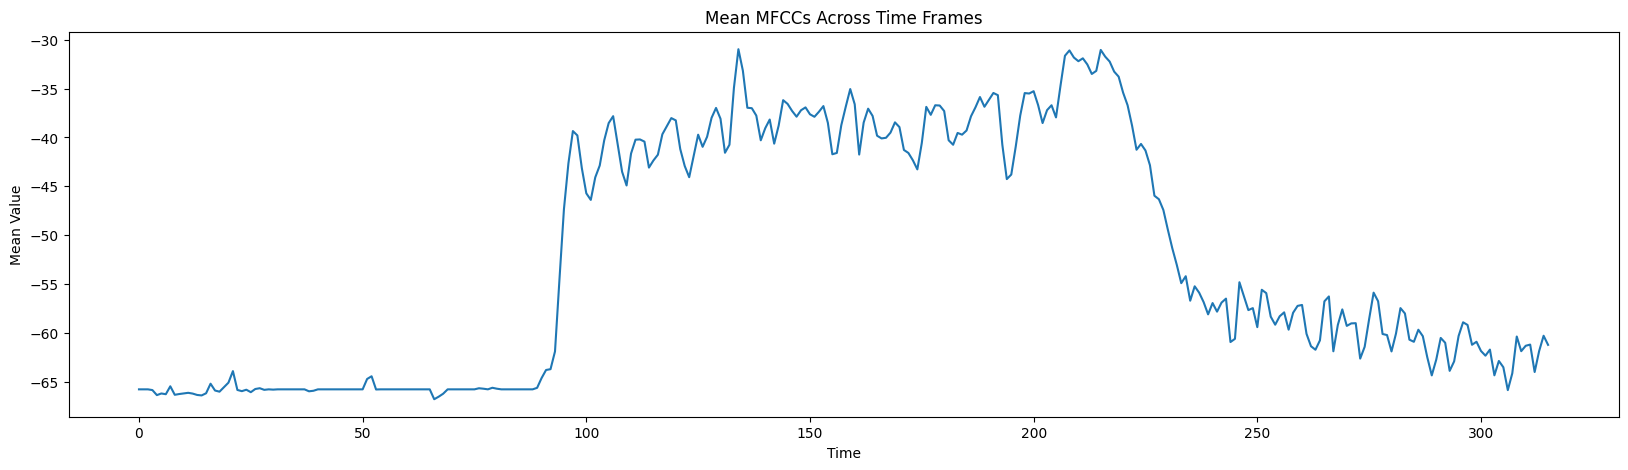

In [25]:
# MFCCs (Mel-Frequency Cepstral Coefficients)
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)
print('Shape of MFCCs:', mfccs.shape)

# Plot the MFCCs as a spectrogram
plt.figure(figsize=(20, 5))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', cmap='viridis')
plt.colorbar()
plt.title('MFCCs')
plt.show()

# Plot the mean of the MFCCs across time (mean per coefficient)
plt.figure(figsize=(20, 5))
plt.plot(np.mean(mfccs, axis=1))
plt.title('Mean MFCCs Across Time')
plt.xlabel('MFCC Coefficients')
plt.ylabel('Mean Value')
plt.show()

# Plot the mean of the MFCCs across coefficients (mean per time frame)
plt.figure(figsize=(20, 5))
plt.plot(np.mean(mfccs, axis=0))
plt.title('Mean MFCCs Across Time Frames')
plt.xlabel('Time')
plt.ylabel('Mean Value')
plt.show()

### FEATURE EXTRACTION

In [26]:
import librosa
import soundfile as sf
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [27]:
file = filenames[0]  # 첫 번째 파일
try:
    with sf.SoundFile(file) as sound_file:
        X = sound_file.read(dtype="float32")
        print(f"데이터 크기: {X.shape}")
except Exception as e:
    print(f"오류 발생: {e}")


데이터 크기: (158558,)


In [28]:
print(f"First 5 filenames: {filenames[:5]}")


First 5 filenames: ['/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav']


In [29]:
# 증강 함수 정의
def add_white_noise(data, noise_factor=0.005):
    """백색 잡음을 신호에 추가"""
    noise = np.random.randn(len(data))  # noise는 1D 배열로 생성되어야 함
    augmented_data = data + noise_factor * noise  # 차원이 동일한 경우에만 연산
    return augmented_data

def pitch_shift(data, sr, n_steps=2):
    """신호의 피치를 n_steps만큼 시프트"""
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)


In [30]:
import numpy as np
import soundfile as sf
import librosa

# 오류 및 처리 로그를 위한 카운터
processed_count = 0
skipped_count = 0
error_log = []

# load_audio 함수 정의
def load_audio(file_name):
    """
    오디오 파일을 로드하고, 데이터와 샘플레이트를 반환합니다.
    """
    try:
        # librosa를 사용해 오디오 파일 로드
        audio, sample_rate = librosa.load(file_name, sr=None)  # 원본 샘플레이트 유지
        return audio, sample_rate
    except Exception as e:
        print(f"오디오 로드 오류: {e} (파일: {file_name})")
        return None, None

# extract_feature 함수 수정
def extract_feature(file_name, mfcc=True, mel=True, augment=True, noise_factor=0.005, n_steps=2):
    global processed_count, skipped_count, error_log
    try:
        # 오디오 파일 로드
        audio, sample_rate = load_audio(file_name)
        if audio is None:
            print(f"오디오 로드 실패: {file_name}")
            return None

        # 스테레오 데이터를 모노로 변환
        if audio.ndim == 2:
            audio = np.mean(audio, axis=1)

        # 증강 기법 적용 (선택적으로 사용)
        if augment:
            audio = add_white_noise(audio, noise_factor=noise_factor)  # 백색 잡음 추가
            audio = pitch_shift(audio, sr=sample_rate, n_steps=n_steps)  # 피치 시프트 적용

        result = np.array([])

        # 최소 샘플 길이 확인 (너무 짧은 신호는 건너뜀)
        if len(audio) < 1000 or np.sum(np.abs(audio)) < 1e-3:
            print(f"신호가 너무 짧거나 무음입니다: {file_name}")
            return None

        n_fft = max(512, min(2048, len(audio) // 2))

        # MFCC 추출 및 평균 계산
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))

        # Mel-Spectrogram 추출 및 평균 계산
        if mel:
            mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft).T, axis=0)
            result = np.hstack((result, mel_spectrogram))

        processed_count += 1
        return result

    except Exception as e:
        print(f"특징 추출 오류: {e} (파일: {file_name})")
        skipped_count += 1
        return None


In [31]:
print(f"First 5 filenames: {filenames[:5]}")


First 5 filenames: ['/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav']


In [32]:
from collections import Counter

In [33]:
from tqdm import tqdm
from collections import Counter
import numpy as np

def load_data(dataset_files, dataset_name, augment=True, noise_factor=0.005, n_steps=2):
    """
    데이터셋별로 데이터를 로드하고, 라벨링 및 특징을 추출하며 성공률과 진행률을 표시합니다.
    """
    x = []
    y = []
    failed_files = []
    success_count = 0  # 성공 파일 수 카운터
    total_files = len(dataset_files)  # 총 파일 수

    # tqdm 진행률 바 설정 (전체 진행률 표시)
    pbar = tqdm(total=total_files, desc=f"Processing {dataset_name}", unit="file", leave=True, position=0)

    for file_path in dataset_files:
        try:
            # 데이터셋별 라벨링
            if dataset_name == "RAVDESS":
                label = get_emotion_label_ravdess(file_path)
            elif dataset_name == "TESS":
                label = get_emotion_label_tess(file_path)
            elif dataset_name == "SAVEE":
                label = get_emotion_label_savee(file_path)
            else:
                raise ValueError("Unknown dataset name")

            # 라벨링 실패 처리
            if label == "unknown":
                failed_files.append((file_path, "Unknown label"))
                pbar.update(1)  # 진행률 업데이트
                continue

            # 원본 데이터 처리
            feature = extract_feature(file_path, augment=False)
            if feature is not None:
                x.append(feature)
                y.append(label)
                success_count += 1
            else:
                failed_files.append((file_path, "Feature extraction failed"))
                pbar.update(1)  # 진행률 업데이트
                continue

            # 증강 데이터 처리 (옵션)
            if augment:
                feature_augmented = extract_feature(file_path, augment=True, noise_factor=noise_factor, n_steps=n_steps)
                if feature_augmented is not None:
                    x.append(feature_augmented)
                    y.append(label)
                    success_count += 1
                else:
                    failed_files.append((file_path, "Augmentation failed"))

            # 진행률 업데이트
            pbar.set_postfix({"Success rate (%)": f"{(success_count / total_files) * 100:.2f}"}, refresh=True)
            pbar.update(1)

        except Exception as e:
            # 일반 오류 처리
            failed_files.append((file_path, f"Error: {e}"))
            pbar.update(1)

    pbar.close()

    # 최종 결과 출력
    print(f"\n{dataset_name} 처리 완료:")
    print(f"- 총 파일 수: {total_files}")
    print(f"- 성공 파일 수: {success_count}")
    print(f"- 실패 파일 수: {len(failed_files)}")
    print(f"- 성공률: {(success_count / total_files) * 100:.2f}%")

    # 실패 파일 목록 출력 (실패 파일이 존재하는 경우에만)
    if failed_files:
        print(f"\n{dataset_name} 실패 파일 목록:")
        for file, reason in failed_files:
            print(f"파일: {file}, 사유: {reason}")

    # 라벨별 성공 파일 수 출력
    label_counts = Counter(y)
    print(f"\n{dataset_name} 라벨별 성공 파일 개수:")
    for label, count in label_counts.items():
        print(f"{label}: {count} files")

    return np.array(x), np.array(y), failed_files


In [34]:
print(f"First 5 filenames: {filenames[:5]}")

print(f"총 파일 개수: {len(filenames)}")


First 5 filenames: ['/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav', '/content/drive/My Drive/Yepi/Data/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav']
총 파일 개수: 8000


In [35]:
!pip install tensorflow
!pip install keras
!pip install tqdm

In [36]:
# 추출 함수 완료 후 요약 출력 함수
def print_summary():
    print(f"처리된 파일 개수: {processed_count}")
    print(f"제외된 파일 개수: {skipped_count}")
    print("오류 로그:")
    for error in error_log:
        print(error)

In [37]:
# RAVDESS 데이터 처리
ravdess_x, ravdess_y, ravdess_failed_files = load_data(
    dataset_files=ravdess_files,
    dataset_name="RAVDESS",
    augment=True
)


Processing RAVDESS: 100%|██████████| 1440/1440 [05:49<00:00,  4.12file/s, Success rate (%)=200.00]


RAVDESS 처리 완료:
- 총 파일 수: 1440
- 성공 파일 수: 2880
- 실패 파일 수: 0
- 성공률: 200.00%

RAVDESS 라벨별 성공 파일 개수:
neutral: 192 files
calm: 384 files
happy: 384 files
sad: 384 files
angry: 384 files
fearful: 384 files
disgust: 384 files
surprised: 384 files


In [38]:
# TESS 데이터 처리
tess_x, tess_y, tess_failed_files = load_data(
    dataset_files=tess_files,
    dataset_name="TESS",
    augment=True
)


Processing TESS: 100%|██████████| 5600/5600 [10:01<00:00,  9.32file/s, Success rate (%)=200.00]


TESS 처리 완료:
- 총 파일 수: 5600
- 성공 파일 수: 11200
- 실패 파일 수: 0
- 성공률: 200.00%

TESS 라벨별 성공 파일 개수:
fearful: 1600 files
happy: 3200 files
sad: 1600 files
angry: 1600 files
disgust: 1600 files
neutral: 1600 files


In [39]:
# SAVEE 데이터 처리
savee_x, savee_y, savee_failed_files = load_data(
    dataset_files=savee_files,
    dataset_name="SAVEE",
    augment=True
)


Processing SAVEE: 100%|██████████| 960/960 [03:42<00:00,  4.32file/s, Success rate (%)=200.00]


SAVEE 처리 완료:
- 총 파일 수: 960
- 성공 파일 수: 1920
- 실패 파일 수: 0
- 성공률: 200.00%

SAVEE 라벨별 성공 파일 개수:
angry: 240 files
disgust: 240 files
fearful: 240 files
happy: 240 files
neutral: 480 files
sad: 240 files
surprised: 240 files


In [40]:
# 모든 데이터 병합
data_x = np.vstack((ravdess_x, tess_x, savee_x))
data_y = np.hstack((ravdess_y, tess_y, savee_y))

# 최종 데이터셋 정보 출력
print(f"\n최종 데이터셋 크기:")
print(f"- Feature array shape: {data_x.shape}")
print(f"- Number of labels: {len(data_y)}")


최종 데이터셋 크기:
- Feature array shape: (16000, 168)
- Number of labels: 16000


In [41]:
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

def visualize_data(original_data, augmented_data, sr):
    plt.figure(figsize=(12, 6))

    # 원본 데이터 시각화
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(original_data, sr=sr)
    plt.title("Original Audio")

    # 증강된 데이터 시각화
    plt.subplot(2, 1, 2)
    librosa.display.waveshow(augmented_data, sr=sr)
    plt.title("Augmented Audio")

    plt.tight_layout()
    plt.show()

def compare_data_statistics(original_data, augmented_data):
    print("Original Data Statistics")
    print(f"Mean: {original_data.mean()}, Std: {original_data.std()}")

    print("\nAugmented Data Statistics")
    print(f"Mean: {augmented_data.mean()}, Std: {augmented_data.std()}")

def play_audio(data, sr):
    return ipd.Audio(data, rate=sr)


def debug_augmentation(file_name, noise_factor=0.005, n_steps=2):
    with sf.SoundFile(file_name) as sound_file:
        original_data = sound_file.read(dtype="float32")
        sr = sound_file.samplerate

    # 백색 잡음 추가 및 피치 시프트 적용
    augmented_data = add_white_noise(original_data, noise_factor=noise_factor)
    augmented_data = pitch_shift(augmented_data, sr=sr, n_steps=n_steps)

    # 데이터 시각화
    visualize_data(original_data, augmented_data, sr)

    # 데이터 통계적 비교
    compare_data_statistics(original_data, augmented_data)

    # 원본 및 증강된 오디오 재생
    print("Original Audio:")
    play_audio(original_data, sr)

    print("\nAugmented Audio:")
    play_audio(augmented_data, sr)


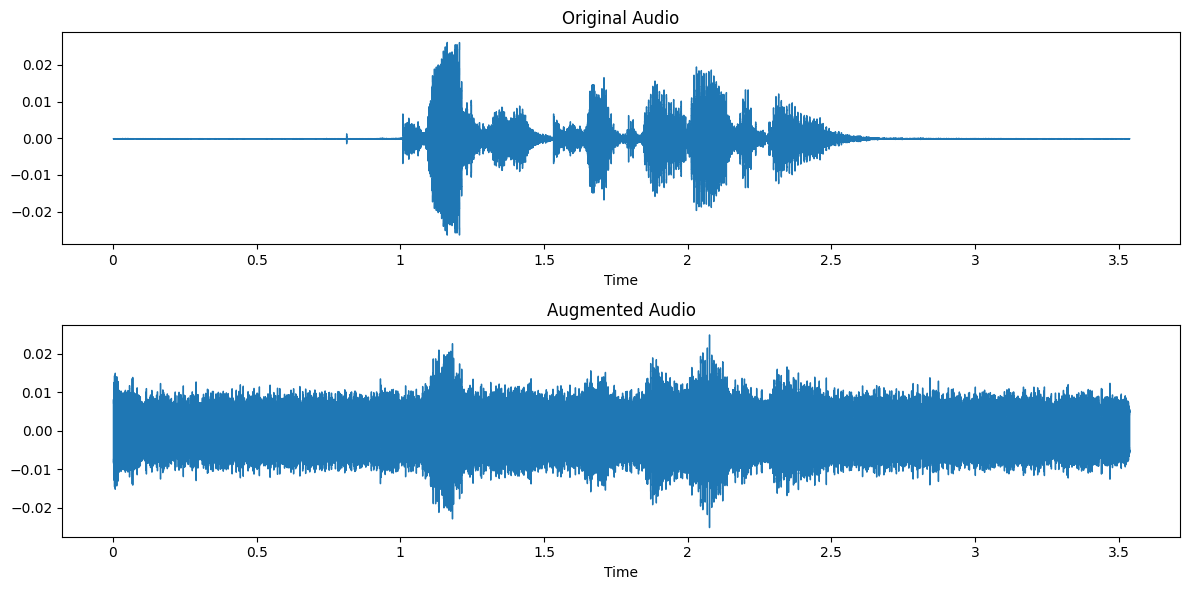

Original Data Statistics
Mean: 8.10894789537997e-07, Std: 0.002956344746053219

Augmented Data Statistics
Mean: 2.724971059460683e-06, Std: 0.003661329994986068
Original Audio:

Augmented Audio:


In [42]:
# 파일 경로 지정 (파일 하나를 선택해서 지정합니다)
file_path = '/content/drive/MyDrive/Data/First/Actor_01/03-01-02-01-01-01-01.wav'

# 해당 파일에 증강을 적용하고 결과를 확인
debug_augmentation(file_name=file_path, noise_factor=0.005, n_steps=2)


In [53]:
from sklearn.model_selection import train_test_split

# 데이터 분리
x_train, x_temp, y_train, y_temp = train_test_split(data_x, data_y, test_size=0.3, random_state=42, stratify=data_y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("데이터셋 분리 결과:")
print(f"Training data: {x_train.shape}, {len(y_train)} labels")
print(f"Validation data: {x_val.shape}, {len(y_val)} labels")
print(f"Testing data: {x_test.shape}, {len(y_test)} labels")


데이터셋 분리 결과:
Training data: (11200, 168), 11200 labels
Validation data: (2400, 168), 2400 labels
Testing data: (2400, 168), 2400 labels


In [54]:
# Conv2D에 맞게 데이터 전처리
if x_train.ndim == 2:  # x_train이 2D 배열인지 확인
    x_train = np.expand_dims(x_train, axis=-1)  # (samples, features, 1)
    x_train = np.expand_dims(x_train, axis=2)  # (samples, features, 1, 1)

if x_test.ndim == 2:  # x_test가 2D 배열인지 확인
    x_test = np.expand_dims(x_test, axis=-1)  # (samples, features, 1)
    x_test = np.expand_dims(x_test, axis=2)  # (samples, features, 1, 1)

# 전처리 결과 확인
print("x_train 원본 데이터 형태:")
print(f"Shape: {x_train.shape}, Data Type: {x_train.dtype}")

print("\nx_test 원본 데이터 형태:")
print(f"Shape: {x_test.shape}, Data Type: {x_test.dtype}")

x_train 원본 데이터 형태:
Shape: (11200, 168, 1, 1), Data Type: float64

x_test 원본 데이터 형태:
Shape: (2400, 168, 1, 1), Data Type: float64


### KERAS MODEL

In [55]:
#Keras-tf model MLP with Dense
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import os
from tqdm import tqdm
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.001)

In [50]:
!pip install resampy


In [56]:
# 감정 레이블 리스트
observed_emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
num_classes = len(observed_emotions)  # 클래스 수 정의

In [57]:
# 데이터 전처리 함수
def preprocess_labels(labels, observed_emotions):
    emotion_mapping = {emotion: idx for idx, emotion in enumerate(observed_emotions)}
    numeric_labels = []
    for label in labels:
        if label in emotion_mapping:
            numeric_labels.append(emotion_mapping[label])
        else:
            print(f"Warning: Label '{label}' not found in observed_emotions. Skipping.")
    return to_categorical(numeric_labels, num_classes=len(observed_emotions))


# 라벨 전처리
y_train = preprocess_labels(y_train, observed_emotions)
y_test = preprocess_labels(y_test, observed_emotions)

# 데이터 확인
print(f"x_train shape: {x_train.shape}, dtype: {x_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")

x_train shape: (11200, 168, 1, 1), dtype: float64
y_train shape: (11200, 8), dtype: float64


In [58]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical
import numpy as np

# 학습 설정
learning_rate = 0.001  # 학습률 설정
loss_type = 'categorical_crossentropy'  # 다중 클래스 분류 손실 함수
activation_output = 'softmax'  # 출력층 활성화 함수

# CNN 모델 생성
def simplified_cnn_model(num_labels, input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Input 레이어로 입력 형태 명시
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))  # Conv2D 사용
    model.add(MaxPooling2D((2, 1)))  # Pooling 크기를 (2, 1)로 조정
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 1)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_labels, activation=activation_output))
    return model

# 입력 형태 설정
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
model = simplified_cnn_model(num_classes, input_shape)

# 옵티마이저 설정
optimizer = Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss_type, metrics=['accuracy'])

# EarlyStopping 콜백 정의
early_stop_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(
    x_train, y_train,
    epochs=60,
    batch_size=64,
    verbose=1,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stop_cb]
)


Epoch 1/60
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4724 - loss: 1.5779 - val_accuracy: 0.7402 - val_loss: 0.7049
Epoch 2/60
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7213 - loss: 0.7612 - val_accuracy: 0.7728 - val_loss: 0.5994
Epoch 3/60
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7518 - loss: 0.6557 - val_accuracy: 0.7741 - val_loss: 0.5577
Epoch 4/60
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7621 - loss: 0.6043 - val_accuracy: 0.8018 - val_loss: 0.5183
Epoch 5/60
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7784 - loss: 0.5793 - val_accuracy: 0.7982 - val_loss: 0.5214
Epoch 6/60
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7780 - loss: 0.5738 - val_accuracy: 0.8000 - val_loss: 0.5009
Epoch 7/60
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7965 - loss: 0.5337 - val_accuracy: 0.8134 - val_loss: 0.4810
Epoch 8/60
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7994 - loss: 0.5258 - val_accuracy: 0

In [59]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8770 - loss: 0.3473
Test Loss: 0.3424847722053528
Test Accuracy: 0.8758333325386047


In [ ]:
# Test the model after training
test_results = model.evaluate(x_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - accuracy: {test_results[1]}%')

y_pred = model.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

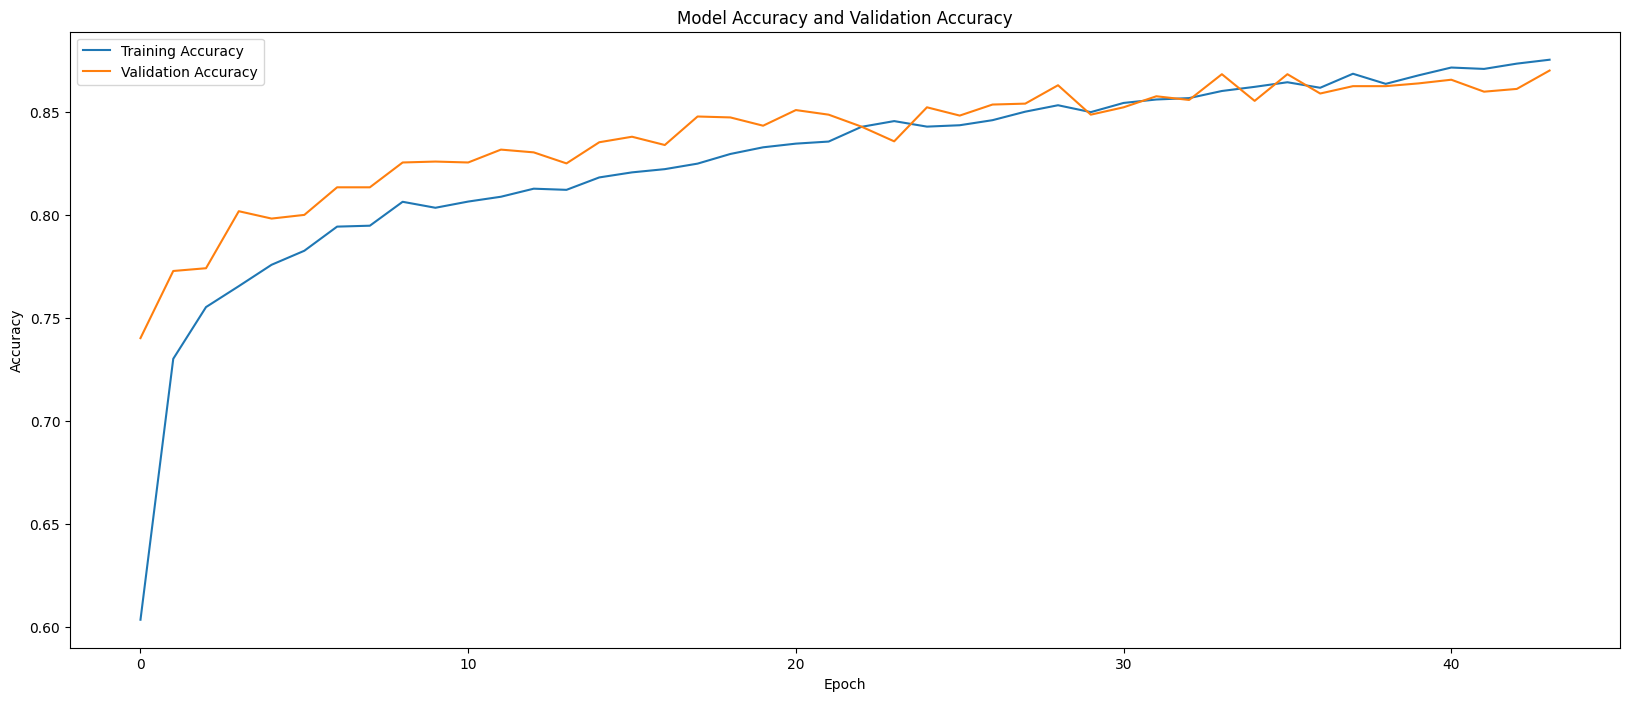

In [60]:

# Ploting accuracy and validation accuracy
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Accuracy and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [61]:
model.save("../output/keras/keras_model.h5")

### SKLEARN MODEL

In [ ]:
# Train SKlean Model

x_train,x_test,y_train,y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=9)

# Scikit learn model MLP
model=MLPClassifier(
    alpha=0.01, batch_size=8, epsilon=1e-08,random_state=1,
    hidden_layer_sizes=(120,100,80,50,30,20,), learning_rate='adaptive',
    max_iter=1500, verbose=0, n_iter_no_change=150
)

model.fit(x_train,y_train)

y_pred=model.predict(x_test)

accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

In [ ]:
# Tuning Hyperparametrs

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model=MLPClassifier(
    batch_size='auto', epsilon=1e-08,random_state=1,learning_rate='adaptive',
    max_iter=100, verbose=0, n_iter_no_change=10
)
parameters = dict(
    alpha=[0.01, 0.001], hidden_layer_sizes=[(120,50,30,), (120,100,)]
)
clf = GridSearchCV(model, parameters)
clf.fit(x_train,y_train)


sorted(clf.cv_results_.keys())

In [ ]:
clf.cv_results_

In [ ]:
clf.best_params_

In [ ]:
clf.best_score_

In [ ]:
clf.best_estimator_

### Running Inference in Notebook


In [ ]:
from tensorflow.keras.models import load_model

# Defining paths for the inference file and model
infer_file_path='../input/Audio_Song_Actors_01-24/Actor_19/03-02-01-01-01-02-19.wav'
infer_model_path = '../output'
framework = 'keras'  # Can change to 'sklearn' if using sklearn
mode = 'infer'


def load_infer_data(filepath):
    '''
    Function to load the infernece data from filepath and extract the features the same way we did for training.
    '''
    file_name=os.path.basename(filepath)
    feature=np.array(extract_feature(filepath))
    print(feature.shape)

    # Printing the feature shape and reshaping it to a single row vector.
    return feature.reshape(1,-1)

In [ ]:
if framework == 'keras':
    model = load_model(infer_model_path + '/keras/keras_model.h5')
else:
    with open(infer_model_path + '/sklearn_model.pkl', 'rb') as f:
        model = pickle.load(f)

In [ ]:
model

In [ ]:
data_x = load_infer_data(infer_file_path)

In [ ]:
predicted_emotion = model.predict(data_x)

In [ ]:
predicted_emotion

In [ ]:
predicted_emotion_index = np.argmax(predicted_emotion)+1

In [ ]:
# Checking the predicted emotion
predicted_emotion_index

In [ ]:
# Printing the predicted emotion
print("Predicted Emotion: ", emotions_id['0'+str(predicted_emotion_index)])

In [ ]:
emotions_id

In [ ]:
import joblib

# Save the model
joblib.dump(model, 'emotion_classifier.pkl')

### Running Inference through CLI

In [ ]:
!python engine.py --infer --infer-model-path ./model --infer-file-path '../input/Audio_Song_Actors_01-24/Actor_19/03-02-01-01-01-02-19.wav'
!python engine.py --train --framework keras